# ClimateBert Sentiment Analysis using the Reddit Climate Change Dataset
by *Harsh Vardhan Pachisia*

March 2024

Lines of code: 735


### Objective

We are analyzing the Reddit Climate Change Dataset to build sentiment models. We are building 3 models: Word2Vec, DistilBERT and ClimateBert, to classify whether a comment in Reddit towards climate change is either positive or negative. In this document, we outline the code used to build a ClimateBert model. The links used for building this out are as follows:

1. https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
2. https://towardsdatascience.com/part-1-data-cleaning-does-bert-need-clean-data-6a50c9c6e9fd
3. https://towardsdatascience.com/does-bert-need-clean-data-part-2-classification-d29adf9f745a
4. https://huggingface.co/climatebert/distilroberta-base-climate-sentiment
5. https://ai.plainenglish.io/bert-pytorch-implementation-prepare-dataset-part-1-efd259113e5a


### 1. Initial Setup

In [ ]:
#running this on CUDA, hence install
!pip install datasets transformers accelerate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
# importing required packages
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from google.colab import drive
from transformers import pipeline
from transformers import TrainingArguments, Trainer

In [ ]:
# switch for using CUDA or on local cpu
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    train_obs = 15000 # seems like a high enough set
    test_obs = 1500
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    train_obs = 3000
    test_obs = 300
    print("Using cpu.")

Using cuda.


In [ ]:
drive.mount("/content/drive")

# Defining data path
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
small_data = True

Mounted at /content/drive


In [ ]:
# Loading data
dtype_dict = {'label': int}
comments = pd.read_csv(data_path + "by_threshold/comments_filtered.csv",
                       quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

### 2. Preprocessing

To figure out the performance of the model, we use a train-test split. Using 20% of the dataset as testing data. Also convert the data into an iterable datset to use Huggingface, using the `from_dict()` method.


In [ ]:
import random
from datasets import Dataset

#same seed across sentiment models
random.seed(120938)

def train_test_split(df, share_test_obs):
  '''
  Function to create a test train split and put the dataset into a format
  that can be used by Huggingface

  Inputs: dataframe and share of test observations

  Returns: train and test dataframes
  '''
  # Identify the observations to assign as test
  num_test_obs = round(df.shape[0] * share_test_obs)
  ids_test_obs = random.sample(range(df.shape[0]), num_test_obs)
  df['test_split'] = 0
  df.loc[ids_test_obs,'test_split'] = 1

  # Fill NaN values with empty strings, otherwise from_dict will raise an error
  df['body'] = df['body'].fillna('')

  # Creates Dataset from dictionary
  train_dict = {"text": df.loc[df['test_split'] == 0, 'body'].tolist(),
                "label": df.loc[df['test_split'] == 0, 'label'].tolist()}
  test_dict = {"text": df.loc[df['test_split'] == 1, 'body'].tolist(),
               "label": df.loc[df['test_split'] == 1, 'label'].tolist()}
  train_df = Dataset.from_dict(train_dict)
  test_df = Dataset.from_dict(test_dict)

  return train_df, test_df

In [ ]:
# Create train and test data
train_data, test_data = train_test_split(comments, 0.2)

In [ ]:
# Create a smaller training dataset for faster training times
small_train_dataset = train_data.shuffle(seed=42).select([i for i in list(range(train_obs))])
small_test_dataset = test_data.shuffle(seed=42).select([i for i in list(range(test_obs))])

To [preprocess](https://huggingface.co/docs/transformers/preprocessing#everything-you-always-wanted-to-know-about-padding-and-truncation) our data, we will use [autotokenizer](hhttps://huggingface.co/docs/transformers/model_doc/auto), specifically the pretrained one from [Climate Bert sentiment](https://huggingface.co/climatebert/distilroberta-base-climate-sentiment)


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-sentiment")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Next, we prepare the text inputs for the model for both splits of our dataset (training and test) by using the [map method](https://huggingface.co/docs/datasets/en/process#map) with [batch processing](https://huggingface.co/docs/datasets/en/process#batch-processing):

In [ ]:
# Prepare the text inputs for the model
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
if small_data:
    tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
    tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
else:
    tokenized_train = train_data.map(preprocess_function, batched=True)
    tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

 We use a [Data Collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator) to convert our training samples to PyTorch tensors and concatenate them with the correct amount of [padding](https://huggingface.co/docs/transformers/preprocessing#pad):

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### 3. Training model

For training, we will be using the [Trainer API](https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/trainer#transformers.Trainer), which is optimized for fine-tuning Transformers models such as ClimateBert.

First, we define ClimateBert as our base model:

Note: we need to have `num_labels = 2` since we only have 2 labels. ClimateBert Sentiment has 3 labels, hence, the `ignore_mismatched_sizes` is required. By finetuning/training our model, this issue will be resolved.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model evaluation metrics are critical, we define them below.

In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
  '''
  A function that computes the accuracy and f1 scores of a model
  '''
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions,
                                     references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions,
                         references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

Before training our model, we define the training arguments and define a Trainer with all objects developed (similar to HW assignments).

In [ ]:
output_name = data_path + "climatebert_output/general"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Training our model on the small dataset to finetune it

In [ ]:
trainer.train()

Step,Training Loss
500,0.523000
1000,0.420600
1500,0.336600
2000,0.309700
2500,0.265100


TrainOutput(global_step=2814, training_loss=0.3585746591618151, metrics={'train_runtime': 1818.6024, 'train_samples_per_second': 24.744, 'train_steps_per_second': 1.547, 'total_flos': 4946707300176864.0, 'train_loss': 0.3585746591618151, 'epoch': 3.0})

Computing evaluation metrics to see the accuracy and F1

In [ ]:
trainer.evaluate()

<ipython-input-18-298c21e26da1>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.4414704144001007,
 'eval_accuracy': 0.8293333333333334,
 'eval_f1': 0.8063540090771558,
 'eval_runtime': 22.2942,
 'eval_samples_per_second': 67.282,
 'eval_steps_per_second': 4.216,
 'epoch': 3.0}

Saving the model for reuse later

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_model"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4. Event studies




To find more interesting findings, we will train 5 other models on a subset of subreddits. These models will have different kinds of sentiment and we will test them on the original test data to see how biased the model is once trained on other data.


We choose the subreddits of `australia` and `canada` due to the influence of climate regulation there. We then use `futurology` (for more scientific, positive climate sentiment), `collapse` for negative sentiment, `the_donald` for a Donald Trump specific subreddit which had a lot of anti-climate sentiment. By doing this, we get a broad range of different sentiments on climate.

#### Filtering the data

We'll begin by plotting the average sentiment for each of our categories:

In [ ]:
sub_comments = pd.read_csv(data_path + "by_category/comments_filtered.csv",
                           quoting=csv.QUOTE_NONNUMERIC, dtype=dtype_dict)

In [ ]:
# Define date
sub_comments['date'] = pd.to_datetime(sub_comments['date'])
sub_comments['year'] = sub_comments['date'].dt.to_period('Y').dt.to_timestamp()
sub_comments['year_month'] = sub_comments['date'].dt.to_period('M').dt.to_timestamp()

In [ ]:
# Sentiment by category and year-month
avg_sentiment_cat = sub_comments.groupby(
    ['subreddit.name','year_month']).agg({'sentiment':'mean'}
                                         ).reset_index().rename(
                                             columns={'sentiment':'avg_sentiment'}
                                             )

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def facet_plots(df, categories):
  '''
  A function that creates facet plots of a dataframe

  Inputs: dataframe and categories

  Output: Plots
  '''
    # Calculate global min and max sentiment scores
    global_min = df['avg_sentiment'].min()
    global_max = df['avg_sentiment'].max()

    # Get unique subreddit names
    subreddits = df['subreddit.name'].unique()

    # Determine the number of rows and columns for the subplot grid
    n_cols = 3
    n_rows = (len(subreddits) + n_cols - 1) // n_cols

    # Create a figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4),
                             sharey=False)

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    # Loop over each subreddit and create a plot
    for i, subreddit in enumerate(subreddits):
        # Filter the DataFrame for the current subreddit
        df_sub = df[df['subreddit.name'] == subreddit]

        sns.lineplot(
            data=df_sub,
            x='year_month',
            y='avg_sentiment',
            ax=axes[i]
        )

        # Set plot title and labels
        axes[i].set_title(subreddit)
        axes[i].set_xlabel("Year")
        axes[i].set_ylabel("Average Sentiment")

        axes[i].set_ylim(global_min, global_max)

        # Rotate x-axis labels
        plt.setp(axes[i].get_xticklabels(), rotation=45)

    # Remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

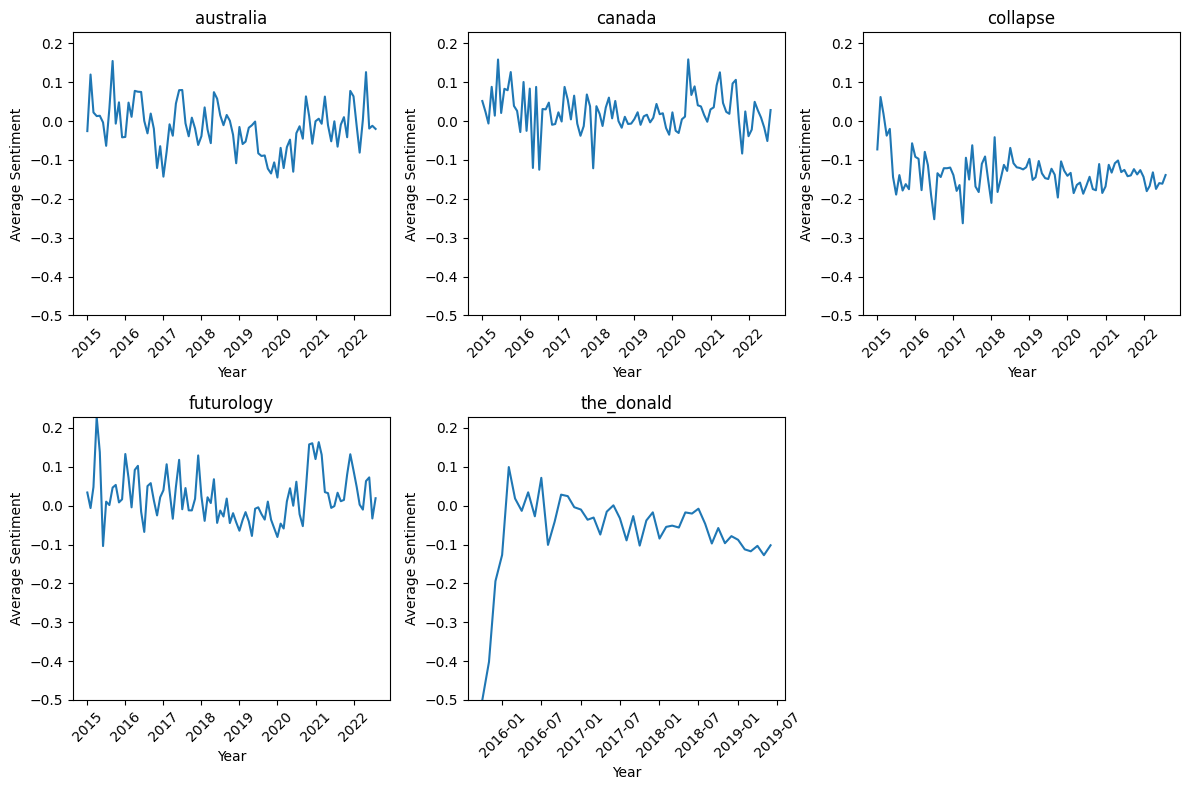

In [ ]:
facet_plots(avg_sentiment_cat, avg_sentiment_cat['subreddit.name'].unique())

As we can see from the previous plot, the average sentiment of three out of five categories is somewhat positive, while the others are more negative. The `the_donald` subreddit was closed in June 2020 due to violation of harassment policies from Reddit.

#### `australia` subreddit

Preprocessing

In [ ]:
australia_comments = sub_comments[sub_comments['subreddit.name']=='australia'].reset_index(drop=True)

In [ ]:
# Obtain train split for each dataset
australia_train, _ = train_test_split(australia_comments, 0.2)

In [ ]:
# Create a smaller training dataset for faster training times
small_australia_train = australia_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
# Tokenize train data
australia_tokenized = small_australia_train.map(preprocess_function, batched=True)

Traing and Testing model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "climatebert_output/australia"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

australia_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=australia_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
australia_trainer.train()

Step,Training Loss
500,0.323900
1000,0.303600
1500,0.282300
2000,0.253300
2500,0.194700


TrainOutput(global_step=2814, training_loss=0.26201923806868976, metrics={'train_runtime': 1706.2644, 'train_samples_per_second': 26.373, 'train_steps_per_second': 1.649, 'total_flos': 4861156128479232.0, 'train_loss': 0.26201923806868976, 'epoch': 3.0})

In [ ]:
australia_trainer.evaluate()

<ipython-input-28-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.5213663578033447,
 'eval_accuracy': 0.8406666666666667,
 'eval_f1': 0.8220402084884586,
 'eval_runtime': 20.2825,
 'eval_samples_per_second': 73.955,
 'eval_steps_per_second': 4.635,
 'epoch': 3.0}

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_australia"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
australia_trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_australia’: File exists


#### `canada` subreddit:

Preprocessing

In [ ]:
canada_comments = sub_comments[sub_comments['subreddit.name']=='canada'].reset_index(drop=True)

In [ ]:
canada_train, _ = train_test_split(canada_comments, 0.2)

In [ ]:
small_canada_train = canada_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
canada_tokenized = small_canada_train.map(preprocess_function, batched=True)

Traing and Testing model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "climatebert_output/canada"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

canada_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=canada_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
canada_trainer.train()

Step,Training Loss
500,0.534600
1000,0.434500
1500,0.350300
2000,0.322400
2500,0.269500


TrainOutput(global_step=2814, training_loss=0.36831414250507366, metrics={'train_runtime': 1780.4023, 'train_samples_per_second': 25.275, 'train_steps_per_second': 1.581, 'total_flos': 5062078125193824.0, 'train_loss': 0.36831414250507366, 'epoch': 3.0})

In [ ]:
canada_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.4247807264328003,
 'eval_accuracy': 0.8273333333333334,
 'eval_f1': 0.807720861172977,
 'eval_runtime': 19.7928,
 'eval_samples_per_second': 75.785,
 'eval_steps_per_second': 4.749,
 'epoch': 3.0}

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_canada"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
canada_trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####`collapse` subreddit:

Preprocessing

In [ ]:
collapse_comments = sub_comments[sub_comments['subreddit.name']=='collapse'].reset_index(drop=True)

In [ ]:
collapse_train, _ = train_test_split(collapse_comments, 0.2)

In [ ]:
small_collapse_train = collapse_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
collapse_tokenized = small_collapse_train.map(preprocess_function, batched=True)

Training and testing model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "climatebert_output/collapse"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

collapse_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=collapse_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
collapse_trainer.train()

Step,Training Loss
500,0.517600
1000,0.433100
1500,0.351600
2000,0.335200
2500,0.266200


TrainOutput(global_step=2814, training_loss=0.36882776017721103, metrics={'train_runtime': 1940.5834, 'train_samples_per_second': 23.189, 'train_steps_per_second': 1.45, 'total_flos': 5493553419859872.0, 'train_loss': 0.36882776017721103, 'epoch': 3.0})

In [ ]:
collapse_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.4244464635848999,
 'eval_accuracy': 0.828,
 'eval_f1': 0.8074626865671642,
 'eval_runtime': 20.9332,
 'eval_samples_per_second': 71.656,
 'eval_steps_per_second': 4.49,
 'epoch': 3.0}

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_collapse"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
collapse_trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### `futurology` subreddit

Preprocessing

In [ ]:
futurology_comments = sub_comments[sub_comments['subreddit.name']=='futurology'].reset_index(drop=True)

In [ ]:
futurology_train, _ = train_test_split(futurology_comments, 0.2)

In [ ]:
small_futurology_train = futurology_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
futurology_tokenized = small_futurology_train.map(preprocess_function, batched=True)

Training and testing model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "climatebert_output/futurology"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

futurology_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=futurology_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
futurology_trainer.train()

Step,Training Loss
500,0.547900
1000,0.435000
1500,0.368800
2000,0.332300
2500,0.273600


TrainOutput(global_step=2814, training_loss=0.3786334272979758, metrics={'train_runtime': 1848.6705, 'train_samples_per_second': 24.342, 'train_steps_per_second': 1.522, 'total_flos': 5242852658494080.0, 'train_loss': 0.3786334272979758, 'epoch': 3.0})

In [ ]:
futurology_trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next majo

{'eval_loss': 0.41651463508605957,
 'eval_accuracy': 0.8366666666666667,
 'eval_f1': 0.8156508653122648,
 'eval_runtime': 21.0343,
 'eval_samples_per_second': 71.312,
 'eval_steps_per_second': 4.469,
 'epoch': 3.0}

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_futurology"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
futurology_trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###`the_donald` subreddit:

Preprocessing

In [ ]:
donald_comments = sub_comments[sub_comments['subreddit.name']=='the_donald'].reset_index(drop=True)

In [ ]:
donald_train, _ = train_test_split(donald_comments, 0.2)

In [ ]:
small_donald_train = donald_train.shuffle(seed=42).select([i for i in list(range(train_obs))])

In [ ]:
donald_tokenized = small_donald_train.map(preprocess_function, batched=True)

Training and testing model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "climatebert/distilroberta-base-climate-sentiment",
    num_labels=2, ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/947 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
output_name = data_path + "climatebert_output/donald"

training_args = TrainingArguments(
   output_dir=output_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
)

donald_trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=donald_tokenized,
   eval_dataset=tokenized_test, # Leave the original one
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [ ]:
donald_trainer.train()

Step,Training Loss
500,0.525200
1000,0.437000
1500,0.336600
2000,0.319900
2500,0.263100


TrainOutput(global_step=2814, training_loss=0.36313325221774084, metrics={'train_runtime': 1696.043, 'train_samples_per_second': 26.532, 'train_steps_per_second': 1.659, 'total_flos': 4763896080622272.0, 'train_loss': 0.36313325221774084, 'epoch': 3.0})

In [ ]:
donald_trainer.evaluate()

<ipython-input-15-dcbaed1ca091>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.4297981858253479,
 'eval_accuracy': 0.8326666666666667,
 'eval_f1': 0.810566037735849,
 'eval_runtime': 21.5712,
 'eval_samples_per_second': 69.537,
 'eval_steps_per_second': 4.358,
 'epoch': 3.0}

In [ ]:
# Use below when on Google Colab.
model_save_directory = "/content/drive/Shareddrives/adv-ml-project/SavedModels/climate_bert_donald"
from google.colab import drive
drive.mount("/content/drive")
!mkdir $model_save_directory

# To save a fine-tuned model
donald_trainer.save_model(model_save_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Testing models on differnt sentences

We want to see how different models classify similar sentences to figure biases in the training data.



In [ ]:
# Specifying the path where the models are stored (last checkpoints)
subreddits = ['australia', 'canada', 'collapse', 'futurology', 'donald']
checkpoint_paths = [
    data_path + 'climatebert_output/' + sub + '/checkpoint-2814' for sub in subreddits]

def model_pipeline(path):
  '''
  Load each model and store in a pipeline

  Inputs: path to saved models

  Output: pipeline of models
  '''
  # Load the tokenizer and model from the checkpoint
  tokenizer = AutoTokenizer.from_pretrained(path)
  model = AutoModelForSequenceClassification.from_pretrained(path)

  # Create a pipeline for sentiment analysis
  sentiment_pipeline = pipeline("sentiment-analysis",
                                model=model,
                                tokenizer=tokenizer)

  return sentiment_pipeline

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
pipelines = [model_pipeline(path) for path in checkpoint_paths]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
test = pipelines[3]
test

In [ ]:
# Example sentences covering a range of sentiments about climate change
sentences = [
    "Innovative renewable energy technologies are revolutionizing our fight against climate change.",
    "Australia's new climate policy promises significant reductions in greenhouse gas emissions.",
    "Canada's carbon tax initiative is a major step forward in environmental conservation.",
    "Claims about climate change are exaggerated and not backed by real science.",
    "Economic growth should not be compromised for the sake of unproven environmental theories.",
    "Many people remain unconvinced about the severity of climate change despite scientific evidence.",
    "Community initiatives and local actions are essential in addressing the impacts of climate change."
]

# Iterate over each sentence
for sentence in sentences:
    print(f"Sentence: {sentence}")

    # Predict the sentiment using each model
    for pipe, model in zip(pipelines, subreddits):
        sentiment = pipe(sentence)
        tag = sentiment[0]['label']
        score = sentiment[0]['score']
        sentiment_type = "negative" if tag == 'LABEL_0' else "positive"

        print(f" - The sentiment using the {model} model is {sentiment_type} with a score of {score:.2f}")

    print()  # For better readability between sentences


Sentence: Innovative renewable energy technologies are revolutionizing our fight against climate change.
 - The sentiment using the australia model is positive with a score of 0.99
 - The sentiment using the canada model is positive with a score of 0.95
 - The sentiment using the collapse model is positive with a score of 0.81
 - The sentiment using the futurology model is positive with a score of 0.94
 - The sentiment using the donald model is negative with a score of 0.58

Sentence: Australia's new climate policy promises significant reductions in greenhouse gas emissions.
 - The sentiment using the australia model is positive with a score of 1.00
 - The sentiment using the canada model is positive with a score of 0.99
 - The sentiment using the collapse model is positive with a score of 0.99
 - The sentiment using the futurology model is positive with a score of 0.99
 - The sentiment using the donald model is positive with a score of 0.99

Sentence: Canada's carbon tax initiative is

##### Adversial testing

In [ ]:
# Sample of 10 adversarial sentences
adversarial_sentences = [
    "Climate change is important, but are we overestimating its impact?",
    "Renewable energy is essential, yet its current form might not be the ultimate solution.",
    "Global warming is serious, however, some solutions might do more harm than good.",
    "Environmental policies are crucial, but excessive regulations can stifle economic growth.",
    "The concept of climate change is widely accepted, yet the approach to tackling it is debatable.",
    "Many support green initiatives, but not everyone agrees on the methods.",
    "Climate change awareness is growing, but misinformation remains a significant issue.",
    "While fossil fuels are harmful, their complete elimination is currently unrealistic.",
    "Sustainable living is essential, yet it's not always practical for everyone.",
    "Carbon footprint reduction is vital, but individual actions alone aren't enough."
]

for sentence in adversarial_sentences:
    print(f"Sentence: \"{sentence}\"")
    for pipe, model in zip(pipelines, subreddits):
        sentiment = pipe(sentence)
        tag = sentiment[0]['label']
        score = sentiment[0]['score']
        sentiment_type = "negative" if tag == 'LABEL_0' else "positive"
        print(f" - {model} model: {sentiment_type} with score {score:.2f}")
    print()

Sentence: "Climate change is important, but are we overestimating its impact?"
 - australia model: negative with score 0.99
 - canada model: negative with score 0.84
 - collapse model: negative with score 0.98
 - futurology model: negative with score 0.96
 - donald model: negative with score 0.97

Sentence: "Renewable energy is essential, yet its current form might not be the ultimate solution."
 - australia model: positive with score 0.97
 - canada model: positive with score 0.96
 - collapse model: positive with score 0.90
 - futurology model: positive with score 0.98
 - donald model: positive with score 0.89

Sentence: "Global warming is serious, however, some solutions might do more harm than good."
 - australia model: negative with score 0.96
 - canada model: negative with score 0.79
 - collapse model: negative with score 0.80
 - futurology model: positive with score 0.94
 - donald model: positive with score 0.70

Sentence: "Environmental policies are crucial, but excessive regulat

##### Blind Test set

In [ ]:
# Assuming the file path to your dataset is 'twitter_sentiment_data.csv'
file_path = data_path + '/twitter_sentiment/' + '/twitter_sentiment_data.csv'

# Read the dataset
twitter_sentiment_data = pd.read_csv(file_path)

# Filter out labels other than 1 and -1
twitter_sentiment_data = twitter_sentiment_data[twitter_sentiment_data['sentiment'].isin([1, -1])]

# Convert -1 to 0
twitter_sentiment_data['sentiment'] = twitter_sentiment_data['sentiment'].replace(-1, 0)

In [ ]:
twitter_sentiment_data = twitter_sentiment_data.rename(
    columns={'sentiment': 'label', 'message': 'text'})
twitter_sentiment_data = twitter_sentiment_data[['text', 'label']]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

results = {}

for model_name, pipeline in zip(subreddits, pipelines):
    predictions = [pipeline(sentence)[0]['label'] for sentence in twitter_sentiment_data['text']]

    accuracy = accuracy_score(twitter_sentiment_data['label'], predictions)
    f1 = f1_score(twitter_sentiment_data['label'], predictions)

    results[model_name] = {'accuracy': accuracy, 'f1_score': f1}

KeyboardInterrupt: 

Comparing models

In [ ]:
model_metrics = {
    'general': {'accuracy': 0.8293333333333334, 'f1_score': 0.8063540090771558},
    'australia':{'accuracy': 0.8406666666666667, 'f1_score': 0.8220402084884586},
    'canada': {'accuracy': 0.8273333333333334, 'f1_score': 0.807720861172977},
    'collapse': {'accuracy': 0.828, 'f1_score': 0.8074626865671642},
    'futurology': {'accuracy': 0.8366666666666667, 'f1_score': 0.8156508653122648},
    'donald': {'accuracy': 0.8326666666666667, 'f1_score': 0.810566037735849}
}

# Convert to a DataFrame
df = pd.DataFrame(model_metrics).transpose()

# Save to a CSV file
csv_file_path = data_path + '/climatebert_output/' + 'model_metrics.csv'
df.to_csv(csv_file_path)

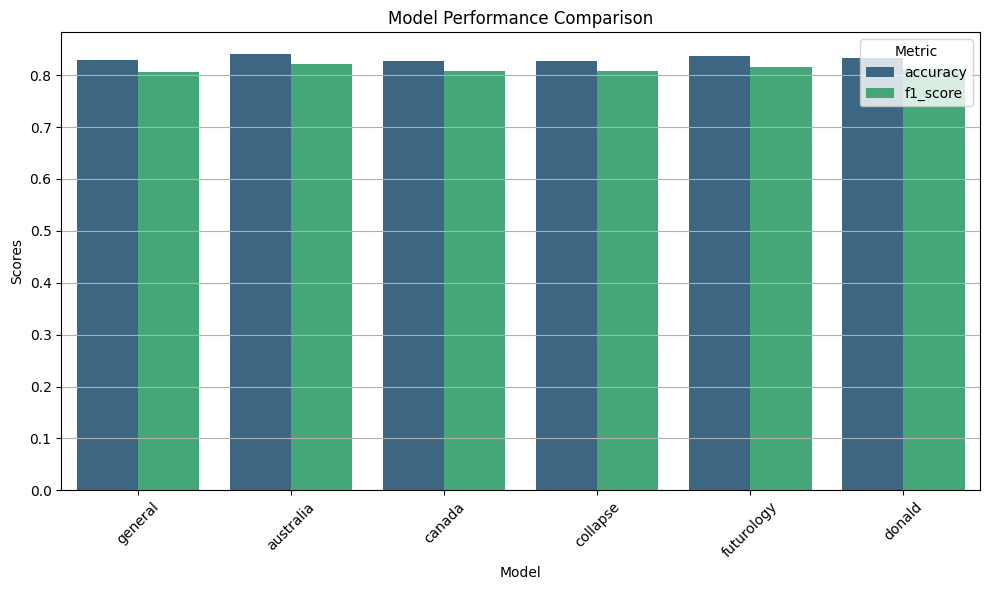

In [ ]:
# Reset the index of the dataframe for better plotting with seaborn
df_reset = df.reset_index()
df_melted = df_reset.melt(id_vars='index', value_vars=['accuracy', 'f1_score'])

plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='value', hue='variable', data=df_melted, palette="viridis")
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.legend(title='Metric')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

Sentiment score distribution:
Analyze the distribution of sentiment scores assigned by each model to understand their tendency towards certain sentiment extremes or neutrality.


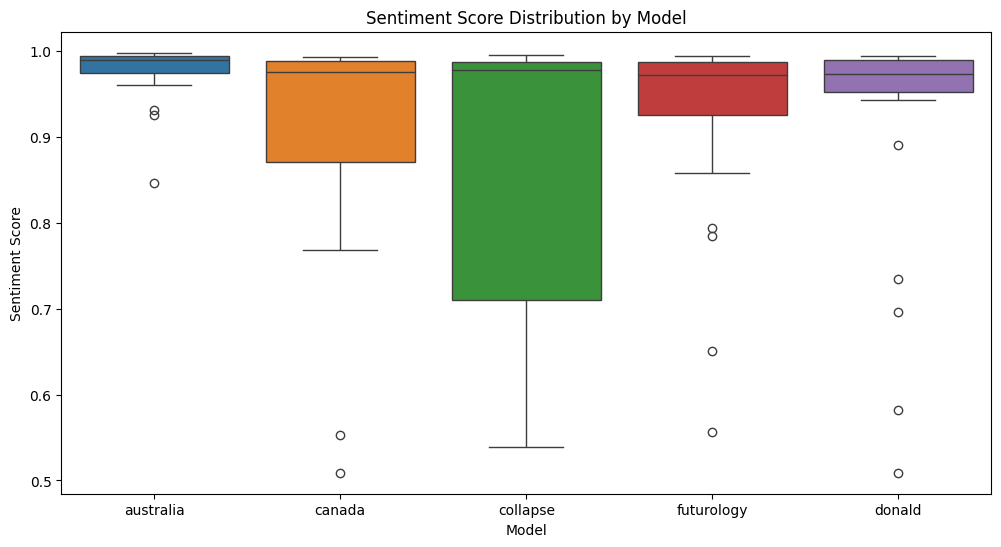

In [ ]:
sentences = ["Climate change is just a natural cycle that has been happening for millions of years.",
    "The economic cost of transitioning to renewable energy is too high for most countries.",
    "Many climate change warnings are just scare tactics with no scientific basis.",
    "Climate models are often inaccurate and should not be trusted to make policy.",
    "Regulations to reduce carbon emissions will hurt businesses and lead to job losses.",
    "There is no consensus among scientists about the causes and impacts of climate change.",
    "Adapting to climate change is more realistic than trying to reverse it.",
    "Renewable energy sources are not reliable enough to replace fossil fuels.",
    "Countries should prioritize economic development over environmental concerns.",
    "Climate change policies are driven by political agendas rather than science.",
    "The push for electric cars ignores the environmental impact of battery production.",
    "Wind farms are a blight on the landscape and harmful to wildlife.",
    "Solar panels require rare earth minerals whose extraction is environmentally damaging.",
    "The climate change debate distracts from more immediate and tangible issues.",
    "Claims that humans are the main cause of climate change are overstated.",
    "Efforts to combat climate change often result in unintended negative consequences.",
    "The focus on climate change leads to neglect of other environmental issues.",
    "Climate change is important, but are we overestimating its impact?",
    "Renewable energy is essential, yet its current form might not be the ultimate solution.",
    "Global warming is serious, however, some solutions might do more harm than good.",
    "Environmental policies are crucial, but excessive regulations can stifle economic growth.",
    "The concept of climate change is widely accepted, yet the approach to tackling it is debatable.",
    "Many support green initiatives, but not everyone agrees on the methods.",
    "Climate change awareness is growing, but misinformation remains a significant issue.",
    "While fossil fuels are harmful, their complete elimination is currently unrealistic.",
    "Sustainable living is essential, yet it's not always practical for everyone.",
    "Carbon footprint reduction is vital, but individual actions alone aren't enough."]

# Dictionary to store sentiment scores from each model
model_scores = {model: [] for model in subreddits}

# Collect sentiment scores
for sentence in sentences:
    for model, pipeline in zip(subreddits, pipelines):
        sentiment = pipeline(sentence)
        score = sentiment[0]['score']
        model_scores[model].append(score)

# Converting the dictionary to a DataFrame for easier plotting
scores_df = pd.DataFrame.from_dict(model_scores, orient='index').transpose()

# Plotting the sentiment score distributions using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=scores_df)
plt.title('Sentiment Score Distribution by Model')
plt.xlabel('Model')
plt.ylabel('Sentiment Score')
plt.show()